In [1]:
! pip install -q kaggle

In [2]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! kaggle datasets download -d adityajn105/flickr8k

 99% 1.03G/1.04G [00:09<00:00, 84.8MB/s]
100% 1.04G/1.04G [00:09<00:00, 114MB/s] 


In [5]:
! ls

drive  flickr8k.zip  kaggle.json  sample_data


In [6]:
! unzip flickr8k.zip

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

In [7]:
! ls

captions.txt  drive  flickr8k.zip  Images  kaggle.json	sample_data


#IMPORTING DEPENDENCIES

In [4]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

#PRE-PROCESSD DATA

In [5]:
BASE_DIR = '/content'
WORKING_DIR = '/content/working'
IMAGE_PATH = '/content/Images'
jpgs = os.listdir(IMAGE_PATH)
print("The number of jpg flies in Dataset: {}".format(len(jpgs)))

The number of jpg flies in Dataset: 8091


#LOAD VGG16 MODEL

In [6]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#FEATURE EXTRACTION

In [7]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

#STORING FEATURES

In [8]:
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [9]:
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [10]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

#MAPPING

In [11]:
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [12]:
len(mapping)

8091

In [13]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [14]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [15]:
clean(mapping)
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [16]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
len(all_captions)

40455

#TOKENIZING TEXT

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8485

In [18]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [19]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

#DATA GENERATOR

In [20]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

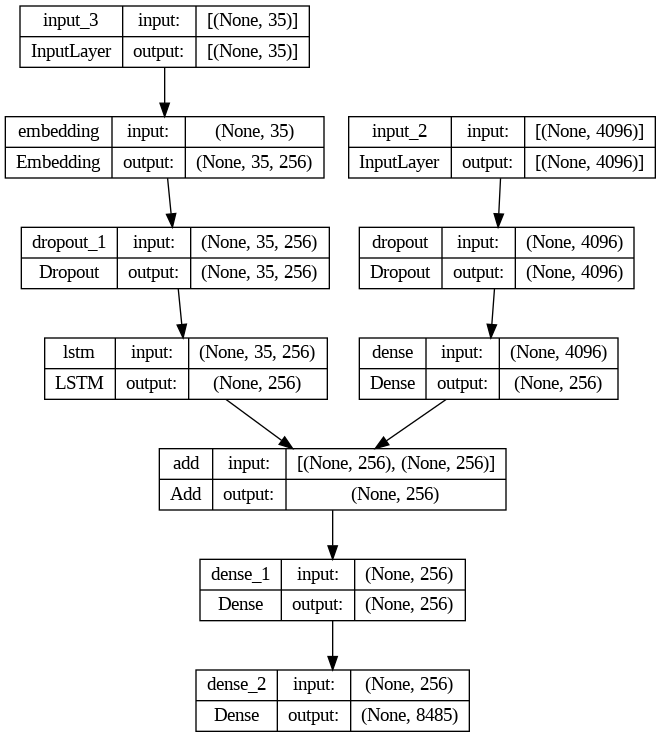

In [21]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

#TRAIN THE MODEL

In [24]:
epochs = 10
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 70s 308ms/step - loss: 2.3616


#SAVING MODEL

In [25]:
model.save(WORKING_DIR+'/caption_model.h5')

In [26]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

#CAPTION GENERATION

In [27]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

In [28]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.538159
BLEU-2: 0.313935


#VISUALIZE RESULTS

In [29]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq man rides his bike on the side of rocky hill endseq
startseq person in black backpack biking on rocky path endseq
startseq person in purple shorts riding bike up mountain endseq
startseq mountain biker approaching cliffside vista endseq
startseq this person is riding bmx bike on clifftop endseq
--------------------Predicted--------------------
startseq man on cliffside bike is on rocky path endseq


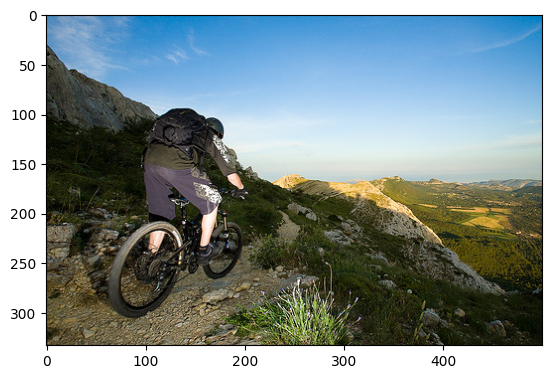

In [81]:
generate_caption("3634281981_d9cf1d1a33.jpg")

---------------------Actual---------------------
startseq cheerleader dressed in red smiles and cheers endseq
startseq smiling blond cheerleader runs with an audience in the background endseq
startseq smiling dancer dressed in red is on the football field with fans in the stadium bleachers behind her endseq
startseq woman in red sports outfit is running on the grass in front of crowd of spectators endseq
startseq woman in red suit is running in field in front of crowd endseq
--------------------Predicted--------------------
startseq woman in red and white uniform is running with crowd in the background endseq


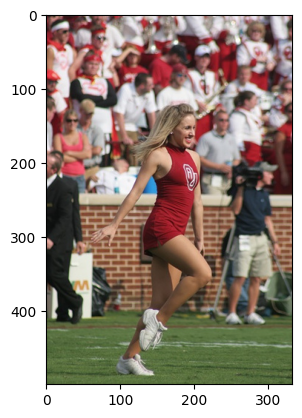

In [82]:
generate_caption("241345656_861aacefde.jpg")

---------------------Actual---------------------
startseq lone snowboarder jumping in the air doing trick endseq
startseq man in black is taking jump on snowboard endseq
startseq person riding snowboard jumps high over the snowy hill endseq
startseq person with yellow and black striped snowboard jumps on the snowy hill endseq
startseq snowboarder jumps off the snow jump endseq
--------------------Predicted--------------------
startseq man in black and black clothes jumping over the snow endseq


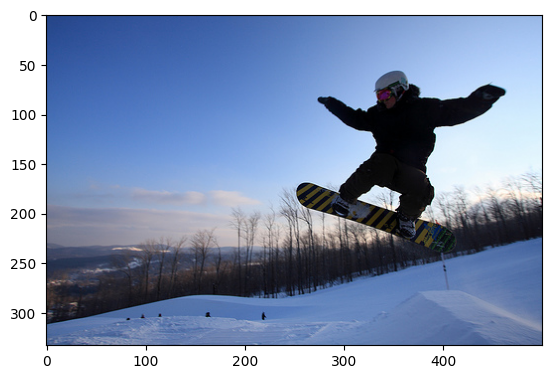

In [83]:
generate_caption("3214237686_6566b8b52f.jpg")

---------------------Actual---------------------
startseq woman and her two dogs are walking down the street endseq
startseq woman wearing cut off shorts walks down the street with dog endseq
startseq the woman in blue shorts and brown vest has black dog to the right of her and dog behind her endseq
startseq the woman is walking her dogs endseq
startseq woman and small black dog walking across pavement endseq
--------------------Predicted--------------------
startseq woman in plaid shirt and shorts is walking down the street endseq


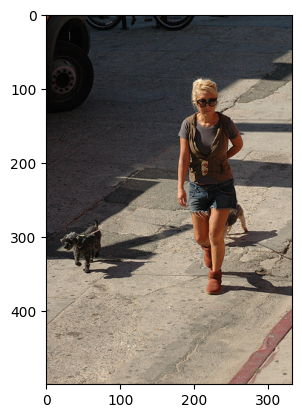

In [84]:
generate_caption("1685463722_55843b6d3c.jpg")

---------------------Actual---------------------
startseq boy dances as another boy stands on short brick wall endseq
startseq two boys are playing on very old architectural structures endseq
startseq two boys play outside building endseq
startseq two people stand outside near an arched doorway endseq
startseq young boys playing in front of fortess gate endseq
--------------------Predicted--------------------
startseq man in blue shirt is climbing stone wall endseq


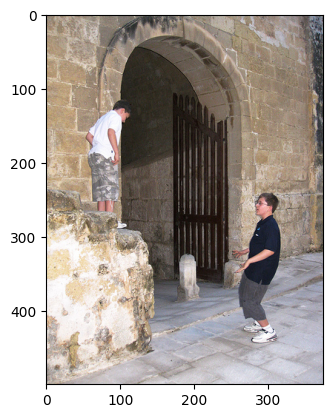

In [85]:
generate_caption("3019667009_20db160195.jpg")

#TEST WITH REAL IMAGE

IMAGE PATH GENERATOR

In [39]:
import os
import random

IMAGE_PATH = '/content/Images'

def get_random_images(directory, num_images):
    image_paths = []

    if not os.path.exists(directory):
        print(f"Directory '{directory}' does not exist.")
        return image_paths

    image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    num_images = min(num_images, len(image_files))

    random_image_indices = random.sample(range(len(image_files)), num_images)

    for index in random_image_indices:
        image_paths.append(os.path.join(directory, image_files[index]))

    return image_paths

num_random_images = 5  # Change this to the number of random images you want
random_image_paths = get_random_images(IMAGE_PATH, num_random_images)

if random_image_paths:
    print("Random image paths:")
    for path in random_image_paths:
        print(path)
else:
    print("No random image paths found.")

Random image paths:
/content/Images/1685463722_55843b6d3c.jpg
/content/Images/518251319_40e031e818.jpg
/content/Images/3214237686_6566b8b52f.jpg
/content/Images/3349194268_0ee555c9a2.jpg
/content/Images/3019667009_20db160195.jpg


In [47]:
vgg_model = VGG16()
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

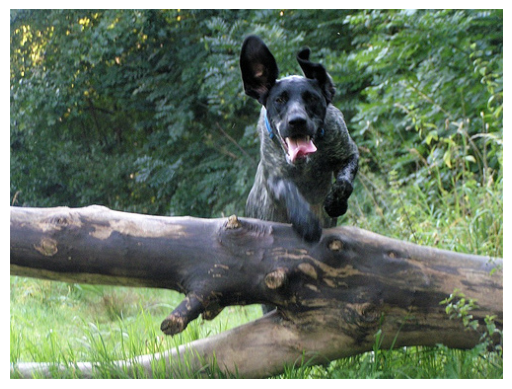

'startseq black and black dog jumps over fallen fence endseq'

In [86]:
image_path = '/content/1015584366_dfcec3c85a.jpg'
image = load_img(image_path, target_size=(224, 224))
image = img_to_array(image)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)
loaded_image = Image.open(image_path)
plt.imshow(loaded_image)
plt.axis('off')  # Turn off axis labels and ticks
plt.show()
feature = vgg_model.predict(image, verbose=0)
predict_caption(model, feature, tokenizer, max_length)